### Instalación de librerias

### Cargue de librerias

In [1]:
import numpy as np
import pandas as pd

np.random.seed(1234)

### Leer los datos

Los datos que se cargaron X_train, y_train, X_test, y_test se encuentran ya divididos, por tanto se procede a trabajar con la data completa para realizar EDA y tener entendimiento de los datos.

In [2]:
# Lee el archivo CSV con separador |
df = pd.read_csv('/content/df_nlp_train_test.csv', sep='|')


In [3]:
df['condition'] = np.where(df['condition']  == "new", "nuevo", "usado")

In [4]:
df.head()

,id,condition,title,dataset
0,1,nuevo,Auriculares Samsung Originales Manos Libres Ca...,train
1,2,usado,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,train
2,3,usado,"Antigua Revista Billiken, N° 1826, Año 1954",train
3,4,nuevo,Alarma Guardtex Gx412 Seguridad Para El Automo...,train
4,5,usado,Serenata - Jennifer Blake,train


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         100000 non-null  int64 
 1   condition  100000 non-null  object
 2   title      100000 non-null  object
 3   dataset    100000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [6]:
df.shape

(100000, 4)

In [7]:
corpus = np.array(df["title"])
id = np.array(df["id"])
labels = np.array(df["condition"])
dataset = df["dataset"]

corpus_df = pd.DataFrame({ 'id': id, 'Document': corpus, 'Category': labels, 'dataset': dataset })
corpus_df.head()


,id,Document,Category,dataset
0,1,Auriculares Samsung Originales Manos Libres Ca...,nuevo,train
1,2,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,usado,train
2,3,"Antigua Revista Billiken, N° 1826, Año 1954",usado,train
3,4,Alarma Guardtex Gx412 Seguridad Para El Automo...,nuevo,train
4,5,Serenata - Jennifer Blake,usado,train


In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

%matplotlib inline

## Pre-procesamiento del texto




In [9]:
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_document(doc):
    # remove special characters:
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    # transform to lower case
    doc = doc.lower()
    # remove \whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 3]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

# crea una función vectorizada para que actué sobre múltiples textos
normalize_corpus = np.vectorize(normalize_document)
#normalize_corpus

In [11]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['auriculares samsung originales manos libres cable oferta',
       'cuchillo daga acero carbn casco yelmo solingen vaina',
       'antigua revista billiken', ..., 'campera cuero negra',
       'psicodrama teatro moderno jean fanchette',
       'libro religioso practicas piadosas fatima'], dtype='<U78')

In [12]:
pip install gensim

In [13]:
from gensim.models import word2vec

In [14]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 25   # Word vector dimensionality
window_context = 5   # Context window size
min_word_count = 1   # Minimum word count
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size,
                              window=window_context, min_count=min_word_count,
                              sample=sample, epochs=100, seed = 1234, workers = 1)


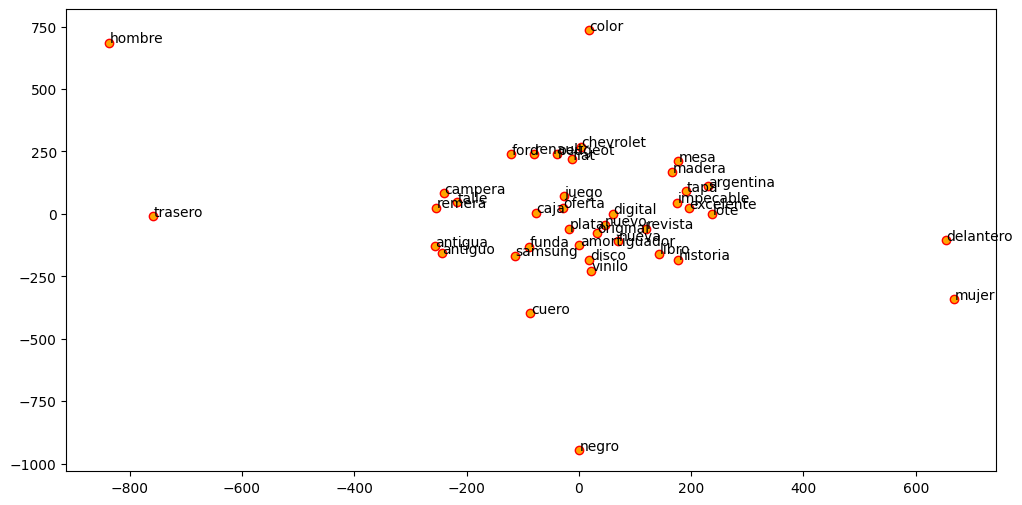

In [15]:
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv.vectors

# Get a subset of the words
words = words[:40]
wvs = wvs[:40, :]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2, n_jobs=-1)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
w2v_model.wv['nuevo']

array([ 2.2605171 ,  0.2661065 ,  0.7547919 , -1.4385865 ,  0.05031933,
       -0.44077808,  0.21579193,  0.9289113 , -0.77922326,  1.0108099 ,
       -1.0461044 ,  1.0026628 ,  0.7295602 , -0.62833655,  1.1571962 ,
       -0.58142865, -2.261718  ,  0.60242826,  4.2761064 , -0.8193261 ,
        0.9408896 ,  0.5844825 ,  1.4651034 ,  0.54012054, -2.6561797 ],
      dtype=float32)

In [16]:
from gensim import corpora
from gensim.models import TfidfModel

In [17]:
def average_word_vectors(words, model, vocabulary, num_features):

    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)

In [18]:
pp = pd.DataFrame(w2v_feature_array)
pp

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.681916,-0.120620,0.453270,-0.162914,-0.132618,3.213534,1.678710,-0.344558,0.937011,0.282577,...,-2.737886,3.895669,-0.963120,3.333806,-1.010470,1.615803,1.349706,0.822313,1.562291,-1.263875
1,-1.199542,-2.096341,0.996000,-1.488510,-0.639225,0.545136,0.502231,1.541887,1.377502,-0.141459,...,-1.854524,2.346117,-0.792638,0.908033,0.657897,-1.607863,-0.984519,-0.687151,-1.557831,-2.229861
2,1.303459,-2.627150,-0.065053,-2.365699,4.331344,0.294372,-2.890121,1.139294,1.837325,-2.990632,...,-0.942880,1.160789,0.396600,0.942073,3.691612,-2.413671,-1.447389,-3.691068,-2.585416,-2.341618
3,-0.130460,-0.259762,0.463712,-0.771028,0.833064,1.226663,-1.950324,-0.985870,-0.011501,1.574957,...,0.485150,3.383554,0.321566,1.285340,-0.419243,-1.037726,-0.454680,-0.462713,0.907802,-0.304470
4,2.015027,0.537005,-0.951190,0.261653,0.167782,-0.236928,0.369885,0.231411,1.367515,0.542014,...,-2.009763,-0.482620,1.976995,-0.511119,-0.522622,-0.141976,0.637989,-1.821740,0.725251,-0.219795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.394020,0.272224,0.227126,-1.647425,-0.182371,-0.542244,0.137052,1.639632,0.425698,-0.048358,...,0.045044,-0.160933,3.598118,0.701075,-1.344567,0.728445,-0.098845,-1.704122,-2.574943,-1.713143
99996,0.828427,-0.392075,-0.809958,-2.971284,1.667210,2.496802,1.236443,0.910453,-1.236033,-1.420228,...,-0.246611,1.085311,0.667793,-0.142104,0.819529,0.413949,0.389214,1.092449,-1.348533,0.035572
99997,-0.706699,-2.336890,-2.030831,-3.606503,1.517634,1.496559,0.626659,-0.308637,0.874896,-2.249028,...,-5.725883,-0.050644,-3.147299,0.975260,-1.084174,0.384478,-2.722857,3.557203,-1.699418,1.021150
99998,0.845586,1.248959,1.019615,-2.547296,1.776418,-0.851432,1.840837,-0.438461,0.546029,0.452412,...,-1.699780,-0.119185,1.519769,0.219492,-0.906283,1.048160,0.158626,0.686189,-2.408492,0.648376


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=15, max_iter=400, tol=0.0001, random_state= 1234)
kmeans.fit(w2v_feature_array)
cluster_labels = kmeans.labels_

cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)


,id,Document,Category,dataset,ClusterLabel
0,1,Auriculares Samsung Originales Manos Libres Cable Usb Oferta,nuevo,train,1
1,2,Cuchillo Daga Acero Carbón Casco Yelmo Solingen Con Vaina,usado,train,1
2,3,"Antigua Revista Billiken, N° 1826, Año 1954",usado,train,0
3,4,Alarma Guardtex Gx412 Seguridad Para El Automotor!!!,nuevo,train,1
4,5,Serenata - Jennifer Blake,usado,train,0
...,...,...,...,...,...
99995,9996,El Corazon De Las Tinieblas - Conrad - Biblioteca 100 X 100,usado,test,0
99996,9997,Juego De Toalla Y Toallon Franco Valente Varios Colores !!,nuevo,test,1
99997,9998,Campera De Cuero Negra,usado,test,1
99998,9999,"Psicodrama Y Teatro Moderno, Jean Fanchette. F2",usado,test,0


In [20]:
result_df = pd.concat([corpus_df, cluster_labels], axis=1)

Accuracy: 0.66215
F1 Score: 0.6913963663600573
Precision: 0.6792297062043469
Recall: 0.7040068454927638


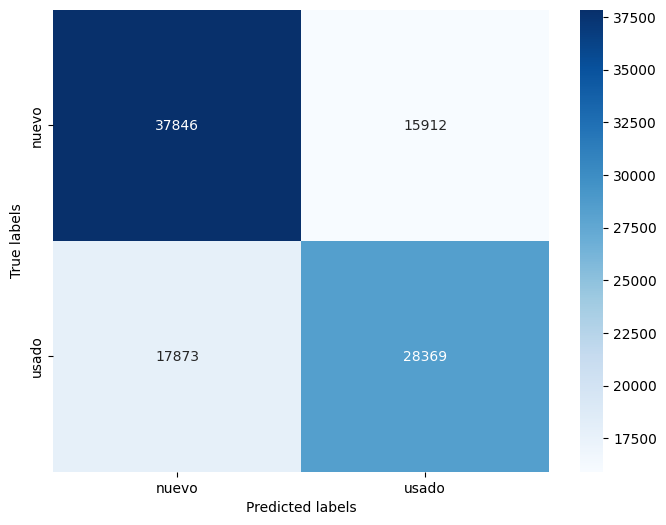

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

# Convertir las etiquetas verdaderas a un formato numérico
true_labels = result_df['Category'].map({'nuevo': 1, 'usado': 0})

# Convertir las etiquetas de cluster a "nuevo" (1) y "usado" (0) basado en la mayoría
if sum(result_df['ClusterLabel'][true_labels == 1]) > sum(result_df['ClusterLabel'][true_labels == 0]):
    cluster_labels = result_df['ClusterLabel'].map({0: 0, 1: 1})
else:
    cluster_labels = result_df['ClusterLabel'].map({0: 1, 1: 0})

# Calcular métricas
print("Accuracy:", accuracy_score(true_labels, cluster_labels))
print("F1 Score:", f1_score(true_labels, cluster_labels))
print("Precision:", precision_score(true_labels, cluster_labels))
print("Recall:", recall_score(true_labels, cluster_labels))

# Construir la matriz de confusión
cm = confusion_matrix(true_labels, cluster_labels, labels=[1, 0])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nuevo', 'usado'], yticklabels=['nuevo', 'usado'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()




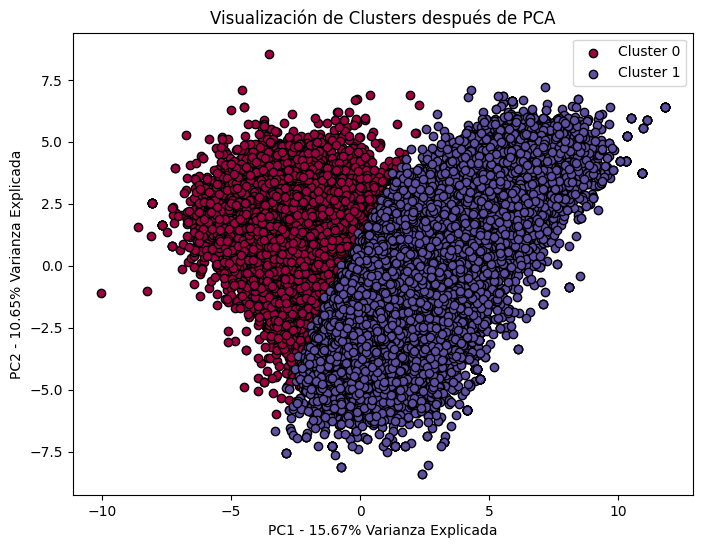

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongo que ya has hecho el clustering y tienes w2v_feature_array y cluster_labels

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)

# Usar un colormap para asignar un color único a cada cluster
unique_labels = np.unique(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

cluster_labels_array = cluster_labels.values.ravel()


plt.figure(figsize=(8, 6))

for i, u_label in enumerate(unique_labels):
    plt.scatter(pcs[cluster_labels_array == u_label, 0],
                pcs[cluster_labels_array == u_label, 1],
                color=colors[i],
                edgecolors='k',
                label=f'Cluster {u_label}')

plt.legend()
plt.title('Visualización de Clusters después de PCA')
plt.xlabel('PC1 - {0}% Varianza Explicada'.format(str(round(100*pca.explained_variance_ratio_[0], 2))))
plt.ylabel('PC2 - {0}% Varianza Explicada'.format(str(round(100*pca.explained_variance_ratio_[1], 2))))

plt.show()



In [23]:
def document_to_vector(doc, model, num_features):
    """Convertir un solo documento en un vector usando un modelo Word2Vec ya entrenado."""
    # Tokenizar el documento
    tokens = wpt.tokenize(doc)
    # Definir el vocabulario del modelo Word2Vec
    vocabulary = set(model.wv.index_to_key)
    # Obtener el vector promedio de todas las palabras tokenizadas
    return average_word_vectors(tokens, model, vocabulary, num_features)

# Suponiendo que 'new_docs' es tu lista de nuevos documentos
new_docs = ["carro para estrenar creo kilometros", "carro antiguo con mas cien mil kilometros"]

# Convertir cada documento en un vector
new_vectors = [document_to_vector(doc, w2v_model, feature_size) for doc in new_docs]

# Etiquetar los nuevos vectores usando KMeans
new_labels = kmeans.predict(new_vectors)

for doc, label in zip(new_docs, new_labels):
    category = 'nuevo' if label == 1 else 'usado'
    print(f"El documento '{doc}' fue asignado a la categoría {category}.")



El documento 'carro para estrenar creo kilometros' fue asignado a la categoría nuevo.
El documento 'carro antiguo con mas cien mil kilometros' fue asignado a la categoría usado.


consideraciones para mejorar el modelo.

1.   Representaciones de Documentos: El enfoque de promediar word embeddings para obtener representaciones de documentos es simple y rápido, pero puede no capturar toda la semántica del documento, especialmente si los documentos son largos.
2. Modelo Word2Vec: La calidad de los embeddings de palabras producidos por el modelo Word2Vec puede afectar los resultados. Considera entrenar el modelo con diferentes parámetros o usar un corpus más grande si es posible.

3. Características del Corpus: Si los documentos tienen muchas palabras en común o son muy similares en términos de contenido, el clustering puede no ser muy distintivo.

4. Preprocesamiento: Asegúrate de que el preprocesamiento esté bien hecho. Las stop words, la tokenización y otros aspectos del preprocesamiento pueden influir en la calidad de los clusters.


A medida que experimentes y ajustes el modelo y el algoritmo, es posible que puedas mejorar la calidad del clustering. También podría ser útil visualizar los clusters para obtener una idea de cómo se están agrupando los documentos.

In [25]:
import pickle

with open('w2v_model.pkl', 'wb') as file:
    pickle.dump(w2v_model, file)

with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [24]:
df_save = pd.concat([corpus_df, cluster_labels], axis=1)
df_save.head()

df_save.to_csv('df_save.csv', sep='|', encoding='utf-8-sig', index=False)